##  Chapter 11: Linear unsupervised learning

# 11.3  Feature scaling via PCA sphereing

In Sections 8.4, 9.4, and 10.3 we have seen how *feature scaling* via *standard normalization* - i.e., by subtracting off the mean of each input feature and dividing off its standard deviation - significantly improves the topology of a supervised learning cost function enabling much more rapid minimization via e.g., gradient descent.  In this Section we describe how PCA is used to perform an advanced form of standard normalization - commonly called *PCA sphereing* (it also referred to as *whitening*).  With this variation on standard normalization we use PCA to rotate the mean-centered dataset so that its largest orthogonal directions of variance allign with the coordinate axes prior to scaling each input by its standard deviation.  This typically allows us to better compactify the data, resulting in a cost function whose contours are even more 'circular' than that provided by standard normalization and thus makes supervised cost functions even easier to optimize.  

In [1]:
# This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
import matplotlib.pyplot as plt
import numpy as np

# custom libs
from mlrefined_libraries import unsupervised_library as unsuplib
from mlrefined_libraries import basics_library as baslib
from mlrefined_libraries import math_optimization_library as optlib
from mlrefined_libraries import superlearn_library as superlearn

unsup_datapath = '../../mlrefined_datasets/unsuperlearn_datasets/'
sup_datapath = '../../mlrefined_datasets/superlearn_datasets/'

normalizers = unsuplib.normalizers
optimizers = optlib.optimizers
cost_lib = superlearn.cost_functions
classification_plotter = superlearn.classification_static_plotter.Visualizer();


# this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

## 11.3.1  The PCA sphereing scheme

Using the same notation as in the previous Section we denote by $\mathbf{x}_p$ the $p^{th}$ input of $N$ dimensions belonging to some dataset of $P$ points.  By stacking these together column-wise we create our $N\times P$ data matrix $\mathbf{X}$.  We then denote $\frac{1}{P}\mathbf{X}\mathbf{X}^T + \lambda \mathbf{I}_{N\times N}$ the regularized covariance matrix of this data and $\frac{1}{P}\mathbf{X}^{\,} \mathbf{X}^T +\lambda \mathbf{I}_{N\times N}= \mathbf{V}^{\,}\mathbf{D}^{\,}\mathbf{V}^T$ its eigenvalue/vector decomposition.

Now remember that when performing PCA we first *mean-center* our dataset - that is we subtract off the mean of each coordinate (note how this is the first step in the standard normalization scheme as well).  We then aim to represent each of our mean-centered datapoints 
datapoint $\mathbf{x}_p$ by $\mathbf{w}_p = \mathbf{V}_{\,}^T\mathbf{x}_p^{\,}$.  In the space spanned by the principal components we can represent the entire set of transformed mean-centered data as 

\begin{equation}
\text{(PCA transformed data)}\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\mathbf{W} = \mathbf{V}^T\mathbf{X}^{\,}.
\end{equation}

With our data not rotated so that its largest orthogonal directions of variacne align with the coordinate axes, to *sphere* the data we simply divide off the standard deviation along each coordinate of the PCA-transformed (mean-centered) data $\mathbf{W}$. 

In other words, PCA-sphereing is simply the standard normalization scheme we have seen before (see e.g., Sections 8.4, 9.4 and 10.3) with a single step inserted in between mean centering and the dividing off of standard deviations: in between these two steps we rotate the data using PCA.  By rotating the data prior to scaling we can typically shrink the space consumed by the data considerably more than standard normalization, while simultaneously making any associated cost function considerably easier to minimize properly.

> PCA-sphereing is simply the standard normalization scheme we have seen before (see e.g., Sections 8.4, 9.4 and 10.3) with a single step inserted in between mean centering and the dividing off of standard deviations: in between these two steps we rotate the data using PCA.  By rotating the data prior to scaling we can typically shrink the space consumed by the data considerably more than standard normalization, while simultaneously making any associated cost function considerably easier to minimize properly.

In the Figure below we show a generic comparison of how standard normalization and PCA sphereing affect a prototypical dataset, and its associated cost function.  Because PCA sphereing first rotates the data prior to scaling it typically results in more compact transformed data, and a transformed cost function with more 'circular' contours (which is easier to minimize via gradient descent).  

<figure>
  <img src= '../../mlrefined_images/unsupervised_images/standard_normal_vs_pca_sphereing.png' width="200%"  height="auto" alt=""/>
      <img src= '../../mlrefined_images/unsupervised_images/standard_vs_sphereing_contours.png' width="90%"  height="auto" alt=""/>
  <figcaption>   
<strong>Figure 1:</strong> <em> The standard normalization procedure (top row) compared to PCA sphereing (middle row) on a generic dataset.  PCA sphereing is simply the standard normalization scheme with a single step inserted in between mean centering and the dividing off of standard deviations: in between these two steps we rotate the data using PCA.  By rotating the data prior to scaling we can typically shrink the space consumed by the data considerably more than standard normalization.  This tends to make any associated cost function considerably easier to minimize properly by better tempering its contours, making them more 'circular' (bottom row). </em>  </figcaption> 
</figure>

More formally if the *standard normalalization* scheme applied to a single datapoint $\mathbf{x}_p$ can be written in two steps as 

---
**Standard normalization scheme:**
1.  **(mean center)** for each $n$ replace $x_{p,n} \longleftarrow \left({x_{p,n} - \mu_n}\right)$ where $\mu_n = \frac{1}{P}\sum_{p=1}^{P}x_{p,n}$
2.  **(divide off std)** for each $n$ replace $x_{p,n} \longleftarrow \frac{x_{p,n}}{\sigma_n}$ where $\sigma_n = \sqrt{\frac{1}{P}\sum_{p=1}^{P}\left(x_{p,n}\right)^2}$
---

A `Python` implementation is given below - notice it returns a `normalizer` function that normalizes any input according to the statistics of $\mathbf{X}$.

In [2]:
# standard normalization function 
def standard_normalizer(x):
    # compute the mean and standard deviation of the input
    x_means = np.mean(x,axis = 1)[:,np.newaxis]
    x_stds = np.std(x,axis = 1)[:,np.newaxis]   

    # create standard normalizer function
    normalizer = lambda data: (data - x_means)/x_stds

    # create inverse standard normalizer
    inverse_normalizer = lambda data: data*x_stds + x_means

    # return normalizer 
    return normalizer,inverse_normalizer

The PCA-sphereing scheme can be then be written in three highly related steps as follows

---
**PCA-sphereing scheme:**
1.  **(mean center)** for each $n$ replace $x_{p,n} \longleftarrow \left({x_{p,n} - \mu_n}\right)$ where $\mu_n = \frac{1}{P}\sum_{p=1}^{P}x_{p,n}$
2.  **(PCA rotation)** transform $\mathbf{w}_p = \mathbf{V}_{\,}^T\mathbf{x}_p^{\,}$ where $\mathbf{V}$ is the full set of eignenvectors of the reguliarzed covariance matrix
3.  **(divide off std)** for each $n$ replace $w_{p,n} \longleftarrow \frac{w_{p,n}}{\sigma_n}$ where $\sigma_n = \sqrt{\frac{1}{P}\sum_{p=1}^{P}\left(w_{p,n}\right)^2}$
---

Below we provide a `Python` implementation of PCA-sphereing.  The input to the function `PCA_sphereing` is a data matrix `x`, and it returns two functions `normalizer` - that one can use to perform sperehing on any input (both training and future test points) - and `inverse_normalizer` that can be used to reverse the operation.  One can notice that the only difference between how the method is detailed above and the actual implementation is implementing step 3 we divide off the square root of the *eigenvalues* of the regularized covariance matrix.  This is done for computational efficiency's sake since - as we discuss in the next Section - the $n^{th}$ eigenvalue $d_n$ actually equals the variance of the PCA-transformed data i.e., $d_n = \sigma_n^2$, so dividing off its square root is equal to dividing off by the standard deviation.

In [3]:
# compute eigendecomposition of data covariance matrix for PCA transformation
def PCA(x,**kwargs):
    # regularization parameter for numerical stability
    lam = 10**(-7)
    if 'lam' in kwargs:
        lam = kwargs['lam']

    # create the correlation matrix
    P = float(x.shape[1])
    Cov = 1/P*np.dot(x,x.T) + lam*np.eye(x.shape[0])

    # use numpy function to compute eigenvalues / vectors of correlation matrix
    d,V = np.linalg.eigh(Cov)
    return d,V

# PCA-sphereing - use PCA to normalize input features
def PCA_sphereing(x,**kwargs):
    # Step 1: mean-center the data
    x_means = np.mean(x,axis = 1)[:,np.newaxis]
    x_centered = x - x_means

    # Step 2: compute pca transform on mean-centered data
    d,V = PCA(x_centered,**kwargs)

    # Step 3: divide off standard deviation of each (transformed) input, 
    # which are equal to the returned eigenvalues in 'd'.  
    stds = (d[:,np.newaxis])**(0.5)
    normalizer = lambda data: np.dot(V.T,data - x_means)/stds

    # create inverse normalizer
    inverse_normalizer = lambda data: np.dot(V,data*stds) + x_means

    # return normalizer 
    return normalizer,inverse_normalizer

#### <span style="color:#a50e3e;">Example 1: </span>  Sphereing a simple unlabeled dataset

With our sphereing implementation defined we can try PCA sphereing out on a dataset.  Here we will use the simple dataset shown in e.g., example 2 of the previous Section.  The next cell runs the sphereing code above, and then the cell after plots comparisons of the a) the original data (left panel), b) the standard normalized data (middle panel), and c) the PCA sphered data (right panel).  Here sphereing drastically improved the distribution of the original dataset, which (if this were a supervised learning dataset) will drastically improve our ability to quickly tune the parameters of a supervised model via gradient / coordinate descent.

<IPython.core.display.Javascript object>


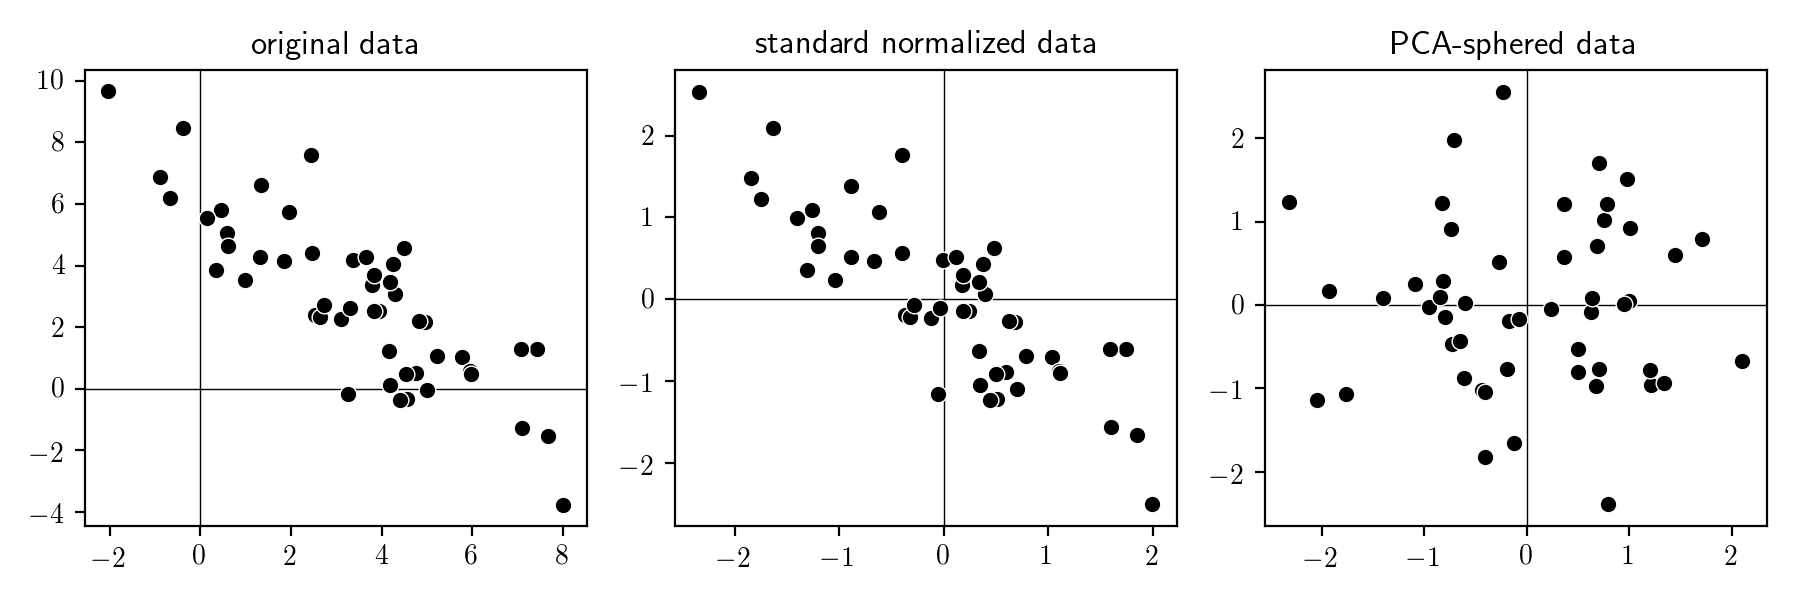

In [4]:
# This code cell will not be shown in the HTML version of this notebook
# load in dataset to perform PCA on
X_original = np.loadtxt(unsup_datapath + '2d_span_data.csv',delimiter=',')

# standard normalize data
standard_func,inverse_standard = standard_normalizer(X_original)
x_standard = standard_func(X_original)

# create PCA sphereing normalizer and normalize data
pca_sphere,inverse_sphere = PCA_sphereing(X_original)
x_sphered = pca_sphere(X_original)

# visualize original and sphered data
plt.figure(figsize = (9,3));
plt.subplot(1, 3, 1)
plt.scatter(X_original[0,:], X_original[1,:],c = 'k',linewidth = 0.5,edgecolor = 'w',zorder = 2)
plt.title('original data'); plt.axhline(0,linewidth = 0.5, color='k',zorder = 1); plt.axvline(0,linewidth = 0.5, color='k',zorder = 1);

plt.subplot(1, 3, 2)
plt.scatter(x_standard[0,:], x_standard[1,:],c = 'k',linewidth = 0.5,edgecolor = 'w',zorder = 2)
plt.title('standard normalized data'); plt.axhline(0,linewidth = 0.5, color='k',zorder = 1); plt.axvline(0,linewidth = 0.5, color='k',zorder = 1);

plt.subplot(1, 3, 3)
plt.scatter(x_sphered[0,:], x_sphered[1,:],c = 'k',linewidth = 0.5,edgecolor = 'w',zorder = 2)
plt.title('PCA-sphered data');  plt.axhline(0,linewidth = 0.5, color='k',zorder = 1); plt.axvline(0,linewidth = 0.5, color='k',zorder = 1);

#### <span style="color:#a50e3e;">Example 2: </span>  Comparing standard normalization to PCA sphereing on a real dataset

In this and the following example we compare runs of gradient descent on various real datasets using a) the original input, b) standard normalized input, and c) PCA sphered input.  The `Python` function can be used to loop over three gradient descent runs using a single cost function with each version of the data loaded in.  Three steplength parameter inputs allow one to adjust and compare steplength choices for each run.

As we saw when comparing standard normalization to original input in Sections 8.4, 9.4, and 10.3 we will typically find that a substantially larger steplength value can be used when comparing a run on original data to one on standard normalized data, and likewise when comparing a run on standard normalized data to one in which the input was first PCA sphered.  The intuition behind why this is possible - first detailed in Section 8.4.3 - is that PCA sphereing tends to make the contours of a cost function even more 'circular' than standard normalization, and the more circular a cost function's contours become the larger the steplength one can use because the gradient descent direction aligns more closely with the direction one must travel in to reach a true global minimum of a cost function.  

In [40]:
# This code cell will not be shown in the HTML version of this notebook
def identity(x):
    normalizer = lambda data: data
    inverse_normalizer = lambda data: data
    return normalizer,inverse_normalizer

def compare_schemes(x,y,costname,countname,alpha1,alpha2,alpha3,max_its):     
    # parameters for all gradient descent runs
    C = len(np.unique(y))
    if C == 2:
        C-=1
    
    # create initialization
    w = 0.5*np.random.randn(x.shape[0]+1,C)
    
    # gradient descent loop
    cost_histories = []
    count_histories = []
    for transform,alpha_choice in zip([identity,standard_normalizer,PCA_sphereing],[alpha1,alpha2,alpha3]): 
        #### transform input data ####
        # transform data
        normalizer,inverse_normalizer = transform(x)

        # normalize input
        x_transformed = normalizer(x)
        
        #### make cost and misclassification counter based on transformed input ####
        # create cost and counter
        cost = cost_lib.choose_cost(x_transformed,y,costname)
        count = cost_lib.choose_cost(x_transformed,y,countname)
        
        #### run gradient descent ####
        # make run of gradient descent
        weight_history,cost_history = optimizers.gradient_descent(cost,alpha_choice,max_its,w)
        
        # compute number of misclassifications
        count_history = [count(v) for v in weight_history]
        cost_histories.append(cost_history)
        count_histories.append(count_history)
    return cost_histories,count_histories

As our first example we compare a runs of gradient descent using a real $N = 8$ input breast cancer dataset, a description of which you can find [here](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)).  Below we load in the data and run the function above (outputting results on the original, standard normalized, and PCA sphered input).

Now we run the comparison module.  For each run we found the largest steplength of the form $\alpha = 10^{-\gamma}$ for an integer $\gamma$ that produced adequate convergence.  Notice that in comparing these values below, that here we can use at least an order of magnitude larger steplength when going from the original, to standard normalized, to PCA sphered input.

In [43]:
# This code cell will not be shown in the HTML version of this notebook
# load in dataset
csvname = sup_datapath + 'breast_cancer_data.csv'
data = np.loadtxt(csvname,delimiter = ',')

# get input/output pairs
x = data[:-1,:]
y = data[-1:,:] 

# run comparison module above
alpha_orig = 10**(-2);  alpha_standard = 1; alpha_pca_sphered = 10; costname = 'softmax'; countname = 'counter';
max_its = 10
cost_histories,count_histories = compare_schemes(x,y,costname,countname,alpha_orig,alpha_standard,alpha_pca_sphered,max_its)

With the runs complete we can now plot the cost and misclassification histories for each run to visually examine and compare the progress of each run.  Examining the plot below we can see how both normalization schemes result in runs that converge much more rapidly than applying gradient descent to the raw data.  Furthermore, the run on PCA sphered input converges more rapidly than the run on standard normalized input.  We can examine this more closely by plotting the corresponding histories of just these two runs - which we do below.

<IPython.core.display.Javascript object>


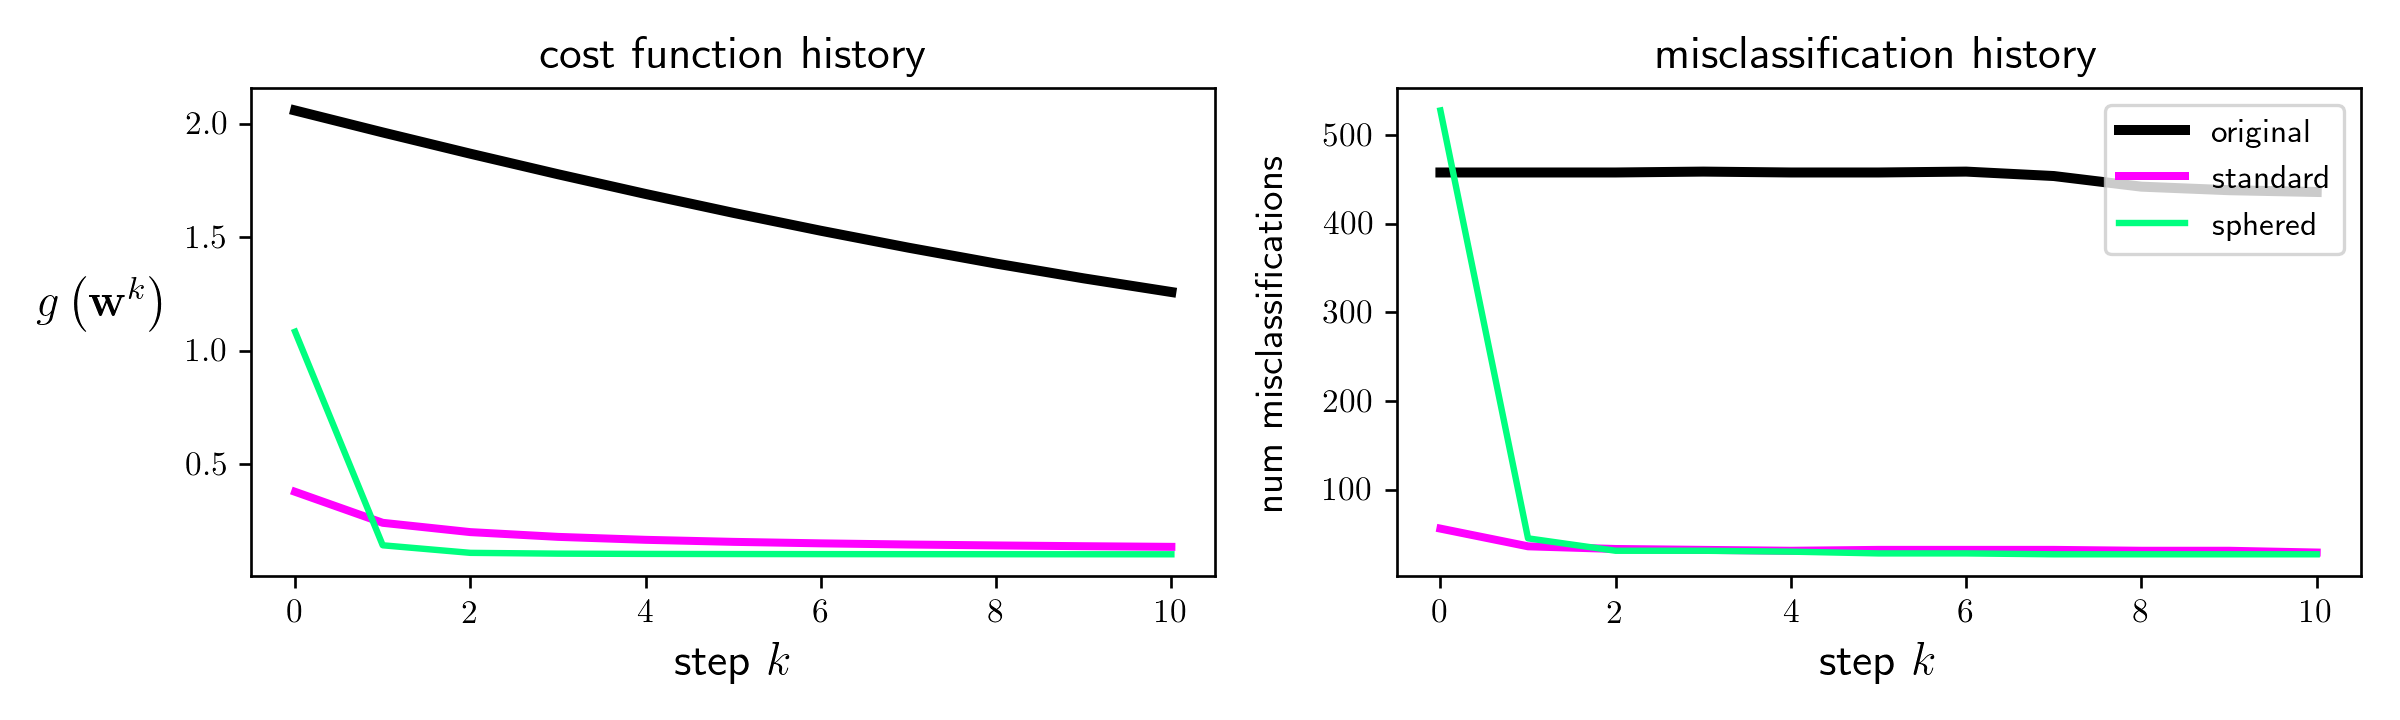

In [44]:
# This code cell will not be shown in the HTML version of this notebook
# plot cost and misclassification histories
classification_plotter.plot_cost_histories(cost_histories,count_histories,start = 0,labels = ['original','standard','sphered'])

Plotting the histories of just the runs on standard normalized and PCA sphered inputs, as is shown below, we can see just how much faster the run on the PCA sphered data converges than the corresponding run on the standard normalized data.  Examining the misclassification history in particular we can see that the PCA sphered data converges almost immediately.  

<IPython.core.display.Javascript object>


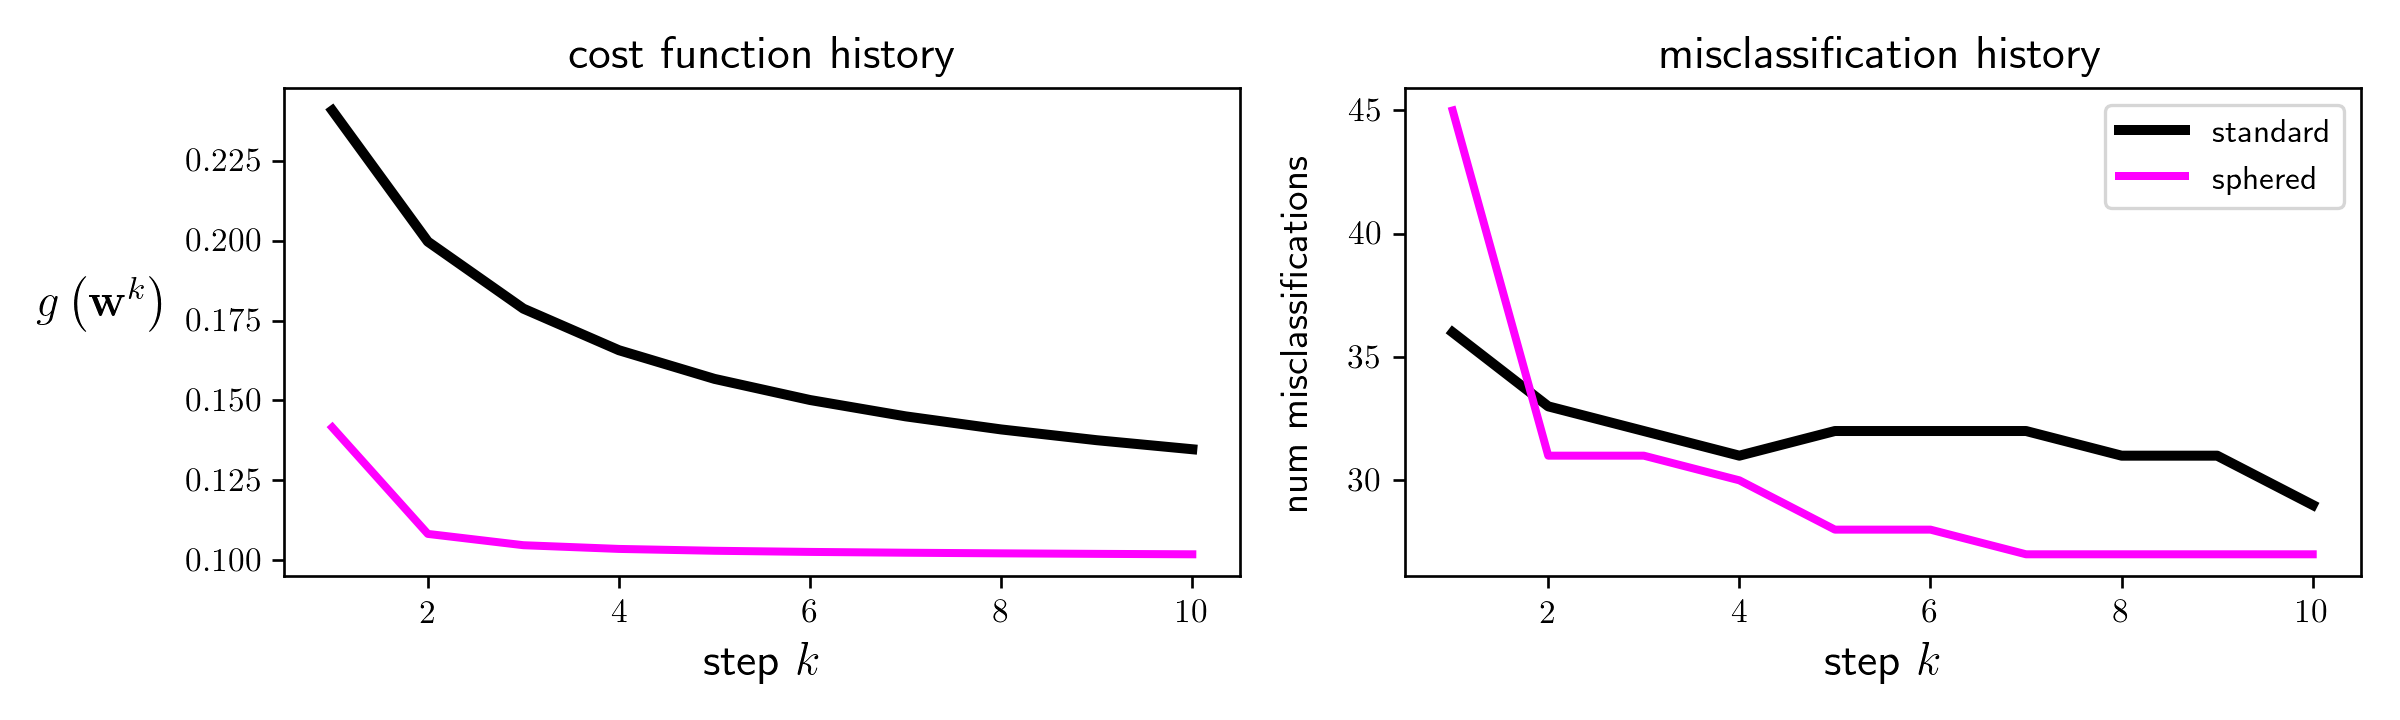

In [45]:
# This code cell will not be shown in the HTML version of this notebook
# plot cost and misclassification histories
classification_plotter.plot_cost_histories(cost_histories[1:],count_histories[1:],start = 1,labels = ['standard','sphered'])

Next we illustrate a run on each type of input using $10,000$ handwritten digits from the [MNIST dataset](http://scikit-learn.org/stable/datasets/index.html) - consisting of hand written digits between 0 and 9.  These images have been contrast normalized, a common pre-processing technique for image based data we discuss in Chapter 16. 

We pick steplength values precisely as done in the previous dataset, and again find that we pick much larger values when comparing runs on the original to that of the standard normalized input, and this to the PCA sphered input.

In [359]:
# This code cell will not be shown in the HTML version of this notebook
# load in mnist test set
csvname = '/Users/Nurgetson/Desktop/mnist/mnist_test_contrast_normalized.csv'
data = np.loadtxt(csvname,delimiter = ',')

# get input/output pairs
x = data[:-1,:]
y = data[-1:,:] 

# run comparison module above
alpha_orig = 10**(-1);  alpha_standard = 1; alpha_pca_sphered = 100;  costname = 'multiclass_softmax'; countname = 'multiclass_counter';
max_its = 10
cost_histories,count_histories = compare_schemes(x,y,costname,countname,alpha_orig,alpha_standard,alpha_pca_sphered,max_its)

Plotting the resulting cost function histories we can see how the run on standard normalized data converges rapidly in comparison to the raw data, and how the run on PCA sphered data converges even more rapidly still.

<IPython.core.display.Javascript object>


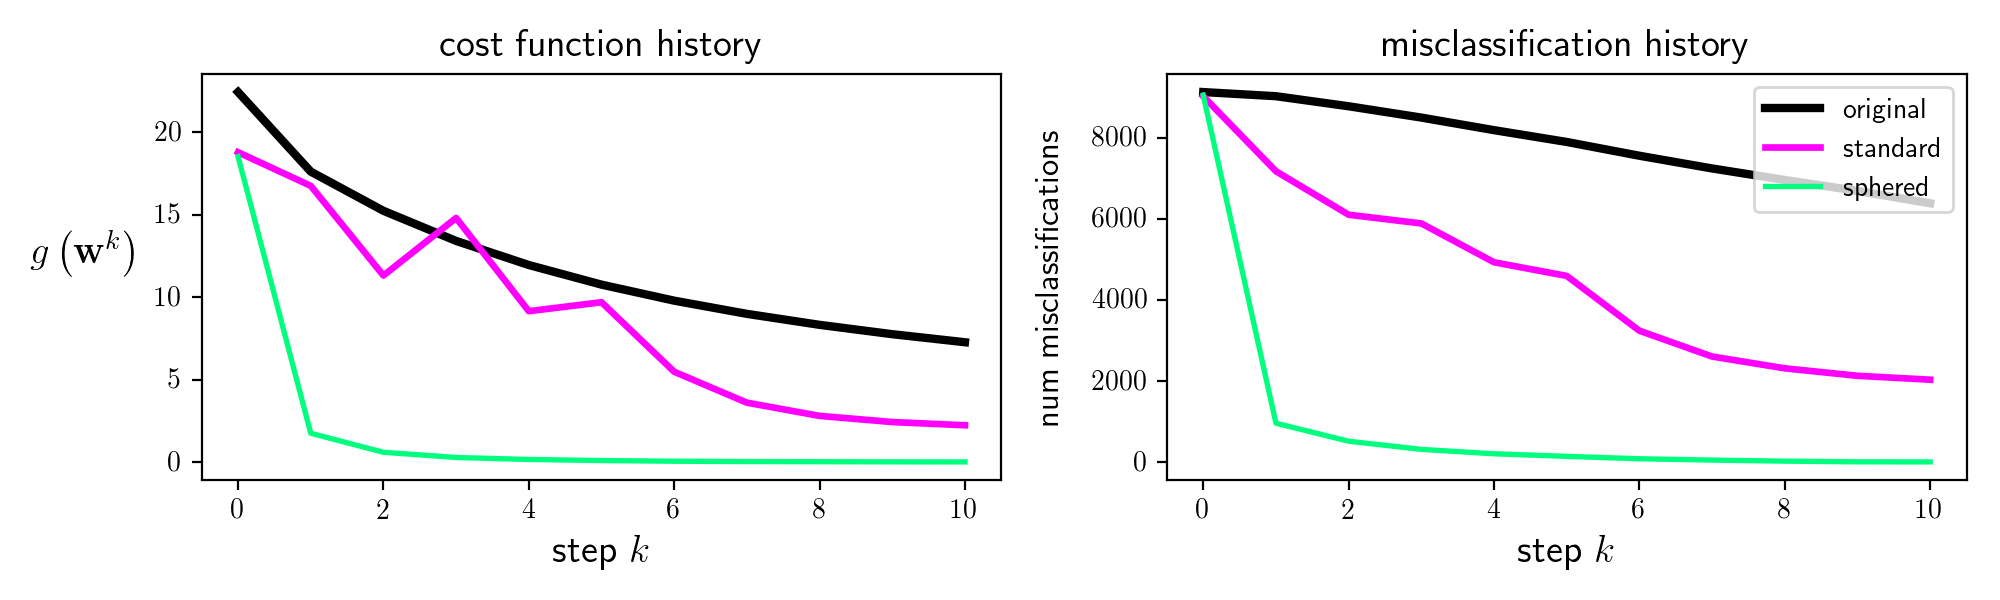

In [360]:
# This code cell will not be shown in the HTML version of this notebook
classification_plotter.plot_cost_histories(cost_histories,count_histories,start = 0,labels = ['original','standard','sphered'])

## 11.3.3  The PCA-sphereing scheme expressed more elegantly 

Here we briefly describe how one can write the PCA-sphereing scheme more elegantly by leveraging our understanding of eigenvalue/vector decompositions.  This will result in precisely the same PCA-sphereing scheme we have seen previously, only written in a prettier / more elegant way mathematically speaking.  This also helps shed some light on the theoretical aspects of this normalization scheme.   However in wading through the mathematical details be sure not to lose the 'big picture' communicated previously: that PCA-sphereing is simply an extension of standard normalization where a PCA rotation is applied after mean centering and before dividing off standard deviations. 

Now, if we so choose we can express steps 2 and 3 of PCA-sphereing in a more mathematically elegant way using the *eigenvalues* of the regularized covariance matrix.  The Raleigh quotient definition (see e.g., the previous Section) of the $n^{th}$ eigenvalue $d_n$ of this matrix states that numerically speaking 

\begin{equation}
d_n = \frac{1}{P}\mathbf{v}_n \mathbf{X}_{\,}^{\,} \mathbf{X}_{\,}^T \mathbf{v}_n 
\end{equation}

where $\mathbf{v}_n$ is the $n^{th}$ and corresponding eigenvector.  Now in terms of our PCA transformed data this is equivalently written as

\begin{equation}
d_n = \frac{1}{P}\left\Vert \mathbf{v}_n^T \mathbf{X} \right \Vert_2^2 = {\frac{1}{P}\sum_{p=1}^{P}\left(w_{p,n}\right)^2}
\end{equation}

or in other words, it is the *variance* along the $n^{th}$ axis of the PCA-transformed data.  Since the final step of PCA-sphereing has us divide off the standard deviation along each axis of the transformed data we can then write it equivalently in terms of the eigenvalues as

---
3).  **(divide off std)** for each $n$ replace $w_{p,n} \longleftarrow \frac{w_{p,n}}{d_n^{1/_2}}$ where $d_n^{1/_2}$ is the square root of the $n^{th}$ eigenvalue of the regularized covariance matrix
 
 ---

Denoting $\mathbf{D}^{-1/_2}$ as the diagonal matrix whose $n^{th}$ diagonal element is $\frac{1}{d_n^{1/_2}}$, we can then (after mean-centering the data) express steps 2 and 3 of the PCA-sphereing algorithm very nicely as 

\begin{equation}
\text{(cleverly-written PCA-sphered data)}\,\,\,\,\,\,\,\,\, \mathbf{S}^{\,} = \mathbf{D}^{-^1/_2}\mathbf{W}^{\,} =  \mathbf{D}^{-^1/_2}\mathbf{V}^T\mathbf{X}^{\,}.
\end{equation}

While expressing PCA-sphereing in may seem largely cosmetic, notice that in the actual implementation (provided above) it is indeed computationally advantageous to simply use the eigenvalues in step 3 of the method (instead of re-computing the standard deviations along each transformed input axis) since we compute them anyway in performing PCA in step 2.

<figure>
  <img src= '../../mlrefined_images/unsupervised_images/pca_sphereing.png' width="200%"  height="auto" alt=""/>
  <figcaption>   
<strong>Figure 1:</strong> <em> PCA-sphereing illustrated. </em>  </figcaption> 
</figure>

Also notice that in writing the method this way we can see how - unlike the standard normalization scheme - in performing PCA sphereing we do truly 'sphere' the data in that 

\begin{equation}
 \frac{1}{P}\mathbf{S}^{\,}\mathbf{S}^T = \mathbf{I}_{N\times N}
\end{equation}

which can be easily shown by simply plugging in the definition of $\mathbf{S}$ and simplifying.  This implies that the contours of any cost function we have seen thus far tend to be highly *spherical*, e.g., in the case of a quadratic like Least Squares for linear regression are perfectly spherical (see the analysis in Section 8.4.3 for further details), and thus will be much easier to optimize.